#Analýza vývoje ceny Bitcoinu v závislosti na sentimentu.
=========================================================

V práci se pokusím zjistit, zda by mohla existovat závislost mezi vývojem ceny Bitcoinu a sentimentem
tweetů, které se týkají Bitcoinu.

Budu vycházet ze 2 datasetů:

1. Dataset tweetů. Obsahuje tweety týkající se Bitcoinu v průběhu 8 hodin. Ačkoliv se k nějakému výsledku podaří dojít, tak se ale také ukáže, že dat je příliš málo a byl by potřeba mnohem delší časový úsek. Odkaz: https://data.world/mercal/btc-tweets-sentiment

2. Dataset obsahující vývoj ceny Bitcoinu. Odkaz: https://www.cryptodatadownload.com/data/bitstamp/

Nejprve naimportujeme potřebné knihovny.

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import copy

Dále si vyčistíme dataset tweetů. Bude stačit si vyrobit novou tabulku se 2 sloupci – datum a čas a poté sentiment tweetu, kde:

1. číslem 1 bude označen pozitivní tweet
2. číslem 0 neutrální tweet
3. číslem -1 negativní tweet

Pandas není schopen celou tabulku správně načíst, protože některé řádky nejsou ve správném formátu. Pomohl jsem si tedy modulem csv, kde načítám každý řádek zvlášť a testuji, jestli má správný počet sloupců. Vytvářím novou tabulku, kde špatné řádky zahazuji. Tuto buňku stačí spustit pouze poprvé, vyrobí se nový čistý dataset, se kterým se bude dále pracovat.

In [2]:
# Stará se o správný převod na nový datumový formát.
def adjust_date(date):
    date_split = date.split()
    day = date_split[2]
    time = date_split[3]

    time_split = time.split(":")

    hour = time_split[0]
    minute = time_split[1]
    sec = time_split[2]
    res = '2018' + '-' + '3-' + day + ' ' + hour + ':' + minute + ':' + sec

    return res

def sentiment_to_numeric(sentiment):
    if sentiment == 'positive': return '1'
    if sentiment == 'neutral': return '0'
    if sentiment == 'negative': return '-1'

def clean_dataset():
    with open('btc_tweets.csv') as test:
        next(test)
        #první řádek nové tabulky – pojmenování sloupců
        rows = [';Date;Sentiment']
        reader = csv.reader(test)
        for row in reader:
            #zahazuji řádky které nemají 10 sloupců
            if len(row) != 10:
                continue
            row = [row[0],adjust_date(row[1][:-10]), sentiment_to_numeric(row[6][2:-2])]
            rows.append(row)

    for i in rows[1:]:
        if len(i) != 3 or not i[0].isdecimal():
            raise Exception

    first = True

    cleaned_dataset = open("cleaned_btc_tweets.csv", 'w')
    for i in rows:
        if first:
            cleaned_dataset.write(i + '\n')
            first = False
            continue
        cleaned_dataset.write(';'.join(i) + '\n')
    cleaned_dataset.close()

clean_dataset()

Dále si načteme vývoj ceny bitcoinu do Dataframe.
Zde je důležité zmínit, že oba datasety pracují s časem v jiném časovém pásmu. Dataset s cenou je v časovém pásmu New Yorku, tweety jsou v Londýnském čase. Tyto časy byly v době, ze které tweety jsou, o 5 hodin posunuté. Takže pokud teď v datech máme údaj o tweetu v 15:00 nějaký den, tak v ale tomuto tweetu časově odpovídá cena v 10:00. Z toho důvodu si cenu posuneme o 5 hodin vpřed.

In [3]:
bitcoin_price = pd.read_csv('btc_price.csv', delimiter=';')
dates_price=pd.to_datetime(bitcoin_price['date'],format = '%Y-%m-%d %H:%M')
dates_price = dates_price + pd.Timedelta(hours=5)
bitcoin_price.index = dates_price

Dále se bude hodit následující funkce, která mi bude schopna vrátit časově posunutou cenu. Bude se hodit, protože mě bude zajímat nejen, zda cena se sentimentem koreluje ve stejném čase, ale zda třeba nekoreluje sentiment se zpožděnou cenou nebo naopak. 

In [4]:
def get_shifted_bitcoin_price(btc_price, datumy, hours):
    dat = datumy + pd.Timedelta(hours=hours)
    bitcoin_price_copy = copy.deepcopy(btc_price)
    bitcoin_price_copy.index = dat
    return bitcoin_price_copy

Ze zajímavosti si vykreslíme, jak vypadá graf vývoje ceny z celkového datasetu.

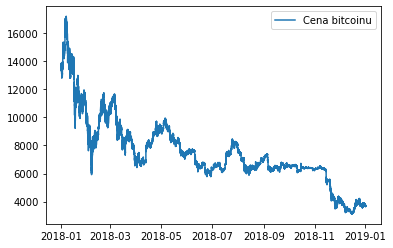

In [5]:
plt.plot(bitcoin_price['low'], label='Cena bitcoinu')
plt.legend()
plt.show()

Dále načteme již vyčištěnou tabulku se sentimentem. Jelikož časový index u tweetů obsahuje i sekundu, zbavíme se toho tím způsobem, že to resamplujeme po 1 minutě a vezmeme z každé této minuty průměr.

In [6]:
tweets_sentiment = pd.read_csv('cleaned_btc_tweets.csv', delimiter=';')
dates_sentiment = pd.to_datetime(tweets_sentiment['Date'], format = '%Y-%m-%d %H:%M')
tweets_sentiment.index = dates_sentiment

#resample
tweets_sentiment = tweets_sentiment.resample('1min').mean()


Opět se podíváme, jak data vypadají. Vidíme, že data jsou z 23.3.2018 od zhruba půlnoci do 8 ráno.
Hodnotz v grafu se pohybují od -1 do 1, což odpovídá sentimentu tweetů. Vidíme, že jsou velice zašuměná.

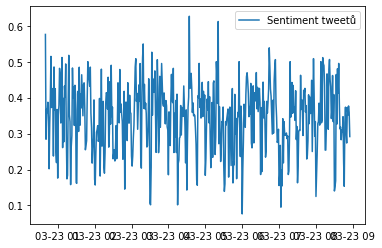

In [7]:
plt.plot(tweets_sentiment['Sentiment'], label='Sentiment tweetů')
plt.legend()
plt.show()

Nyní se dostáváme ke analýze toho, zda sentiment a cena nějak korelují. Tabulku sentimentu a ceny si spojíme do jedné. Kvůli šumu data resamplujeme po 45 minutách. Je ale vhodné zvolit jej tak, aby v grafu bylo alespoň vizuálně dostatek hodnot a zároveň abychom se zbavili šumu a byli schopni pozorovat nějaké případné vlastnosti grafu. Je možné zvolit i jiný interval.
Podíváme se, jak tyto 2 veličiny korelují a vykreslíme graf. Vidíme, že korelace je v tomto případě téměř nulová. 

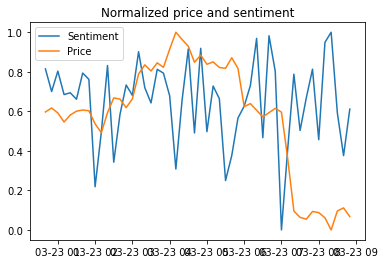

           Sentiment       low
Sentiment   1.000000 -0.047273
low        -0.047273  1.000000


In [15]:
joined_tables = tweets_sentiment.join(bitcoin_price)[['Sentiment', 'low']]
joined_tables = joined_tables.resample('45min').mean()

#Data normalizuji do 0-1
normalized_joined_tables=(joined_tables-joined_tables.min())/(joined_tables.max()-joined_tables.min())

#vykreslim normalizovane grafy vyvoje sentimentu a ceny
plt.title('Normalized price and sentiment')
plt.plot(normalized_joined_tables['Sentiment'], label = 'Sentiment')
plt.plot(normalized_joined_tables['low'], label = 'Price')
plt.legend()
plt.show()

print(normalized_joined_tables.corr())

Následně zkusíme závislost, jestli sentiment závisí na vývoji ceny. Udělám to tím způsobem, že využiji funkce get_shifted_bitcoin_price, kdy data s cenou posunu dopředu. Zkusím posunout o například 5 hodin. Pokud by tedy veličiny v tomto případě korelovaly, mohlo by to naznačovat, že sentiment zhruba s 5 hodinovým zpožděním závisí na ceně. Korelace je ovšem záporná.
V další části zkusím mnoho různých posunutí. Zde je to spíše ilustrace, co dělám.

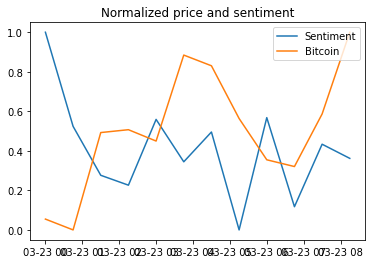

           Sentiment      low
Sentiment    1.00000 -0.39739
low         -0.39739  1.00000


In [9]:
shifted_bitcoin_price = get_shifted_bitcoin_price(bitcoin_price, dates_price, 5)



joined_tables = tweets_sentiment.join(shifted_bitcoin_price)[['Sentiment', 'low']]
joined_tables = joined_tables.resample('45min').mean()

#Data normalizuji do 0-1
normalized_joined_tables=(joined_tables-joined_tables.min())/(joined_tables.max()-joined_tables.min())

#vykreslim normalizovane grafy vyvoje sentimentu a ceny
plt.title('Normalized price and sentiment')
plt.plot(normalized_joined_tables['Sentiment'], label = 'Sentiment')
plt.plot(normalized_joined_tables['low'], label = 'Bitcoin')
plt.legend()
plt.show()

print(normalized_joined_tables.corr())

Zde jsem to posunul opačně – tedy zda sentiment na twitteru nepředchází ceně, opět v řádu 5 hodin. Vidíme, že grafy mají oba klesající tendenci a korelace je v tomto případě vysoká. Šlo by tedy usuzovat, že sentiment na twitteru může být jakási předzvěst následného vývoje ceny. 
Bohužel mě zde brzdí nedostatek dat, který by tuto hypotézu mohl s nějakou rozumnou jistotou přijmout nebo vyvrátit.

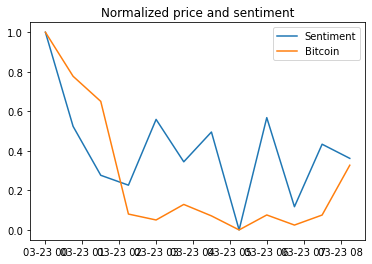

           Sentiment       low
Sentiment   1.000000  0.594795
low         0.594795  1.000000


In [10]:
shifted_bitcoin_price = get_shifted_bitcoin_price(bitcoin_price, dates_price, -5)


joined_tables = tweets_sentiment.join(shifted_bitcoin_price)[['Sentiment', 'low']]
joined_tables = joined_tables.resample('45min').mean()

#Data normalizuji do 0-1
normalized_joined_tables=(joined_tables-joined_tables.min())/(joined_tables.max()-joined_tables.min())

#vykreslim normalizovane grafy vyvoje sentimentu a ceny
plt.title('Normalized price and sentiment')
plt.plot(normalized_joined_tables['Sentiment'], label = 'Sentiment')
plt.plot(normalized_joined_tables['low'], label = 'Bitcoin')
plt.legend()
plt.show()

print(normalized_joined_tables.corr())

Pojďme se ještě podívat, při jakém rozestupu to koreluje nejvíce. Zkusím interval <-24,24>. Hodnoty -5, 0, 5 mám pokryté z předchozích příkladů. 
Je vidět, že při posunu zhruba o -5 hodin k nějakému peaku dochází. Nicméně pak korelace klesá a následně zase naroste při posunu zhruba o +5 hodin. Bohužel není možné z těchto dat cokoliv s jistotou odvozovat. Může se jednat o náhodu, kdy se tam při vyzkoušení mnoha různých posunů nějaká korelace objeví, ale nemusí mít žádné rozumné vysvětlení. 

Bylo by zajímavé mít více dat a pozorovat na na těch předchozích grafech, zda se tam pro nějaké posuny ty grafy chovají podobně v delším horizontu.
Tato práce je ukázka, jak by k takovému problému šlo přistoupit a jak jej analyzovat. 

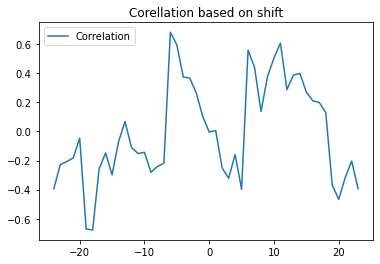

In [13]:
correlations = []
shifts = list(range(-24,24))
for i in shifts:
    data = tweets_sentiment.join(get_shifted_bitcoin_price(bitcoin_price, dates_price, i))[['Sentiment', 'low']]

    #data jsou zasumena, vemu prumer z kazdeho n min useku
    #zkousel jsem resamplovat pro ruzne intervaly
    data = data.resample('45min').mean()


    #data normalizuji do 0-1
    normalized_df=(data-data.min())/(data.max()-data.min())

    #spocitam korelaci
    correlations.append(normalized_df.corr()['Sentiment']['low'])


plt.plot(shifts, correlations, label = 'Correlation')
plt.title('Corellation based on shift')
plt.legend()
plt.show()
